![](https://datahack.analyticsvidhya.com/media/__sized__/contest_cover/1920x480_fiqz1Xl-thumbnail-1200x1200.png)

**INTRODUCTION**

Hello Everyone !

This kernel consists of my work for the India ML Hiring Hackathon on Analytics Vidhya in which we were supposed to predict whether the borrower would default in loan payment in a particular instalment.

It was essentially a binary classification problem.

The Kernel got a highest Public Leaderboard F1 score of **0.336**.

And the highest Cross Validation F1 score achieved is **0.543**.

The highest score achieved on the **Private Leaderboard** is **0.583**

The kernel explains the different steps and decisions I took during the training of the model and the reason behind them too.

**APPROACH**

Before proceeding to the code, I present a brief summary of my approach - 

The dataset provided is **heavily imbalanced** ( around **99.45%:0.55%** for the classes ), hinting towards the possibility of dealing with this problem as a **Anomaly detection** as well as a classification problem.

In order to handle the class imbalance, I used the "**Scale_pos_weight**" parameter present in most of the models and also used Oversampling and Undersampling on the dataset.

Finally, Undersampling using **Tomek Links** aced all other oversampling and undersampling methods, so, i have presented that method in the notebook.

Also, Many new features were designed which have been explained along with the logic behind them, below.

I trained 5 different models trained on 2 types of datasets in order to have a low correlation between the predictions of the model, so that Stacking would be effective.

The 5 models trained were finally stacked and submitted.

**Thresholding** was also used for all the Individual Models as well as the Stacking model so as to give the score a push.

One observation about the dataset was that PCA performed really poor on it, hinting towards the possibility of the train and the test set having different distributions.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from lightgbm import *
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option('display.max.rows',5000)
pd.set_option('display.max.columns',5000)

# Any results you write to the current directory are saved as output.

/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/sample_submission.csv


In [2]:
os.listdir('../input/')

['test.csv', 'train.csv', 'sample_submission.csv']

**Data Pre-Processing**

**Reading and visualizing the dataset.**

In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [5]:
test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


Dropping the 'loan_id' column as we aren't supposed to use that and it wont be of much help anyway, being unique for every row.

In [6]:
train.drop(columns=['loan_id'],inplace=True)
test.drop(columns=['loan_id'],inplace=True)

Let's check for some NaN / Null values present in the dataset

In [7]:
train.isnull().sum()

source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
m13                         0
dtype: int64

In [8]:
test.isnull().sum()

source                      0
financial_institution       0
interest_rate               0
unpaid_principal_bal        0
loan_term                   0
origination_date            0
first_payment_date          0
loan_to_value               0
number_of_borrowers         0
debt_to_income_ratio        0
borrower_credit_score       0
loan_purpose                0
insurance_percent           0
co-borrower_credit_score    0
insurance_type              0
m1                          0
m2                          0
m3                          0
m4                          0
m5                          0
m6                          0
m7                          0
m8                          0
m9                          0
m10                         0
m11                         0
m12                         0
dtype: int64

As we  can see, the dataset has no Null value at all.

Only possible thing which might be there in the dataset is the presence of outliers.

But looking at the sheer volume of the dataset, we can safely assume that the models would not be affected much by the outliers, if sufficient and appropriate regularization is applied.

**Class Distribution**

([<matplotlib.patches.Wedge at 0x7f5e7c85bcc0>,
 [Text(-2.19967398208662, 0.037873110925752615, 'Normal - 99.45%'),
  Text(2.199673985300117, -0.037872924285067416, 'Anomaly - ')])

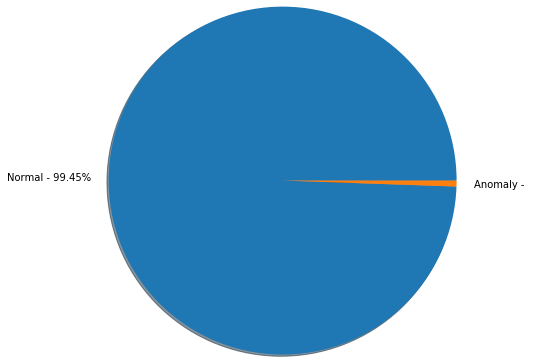

In [9]:
wedge = [train['m13'].value_counts()[0],train['m13'].value_counts()[1]]

perc = [train['m13'].value_counts()[0]/len(train),
        train['m13'].value_counts()[1]/len(train)
       ]
plt.pie(wedge,labels=['Normal - '+ format(perc[0]*100, '.2f') + '%','Anomaly - '],
        shadow=True,radius = 2.0)

As we can see, the dataset is **HEAVILY IMBALANCED** and hence, we need to keep this in mind as this might make models to be biased.

Also, with such heavy imbalance in the dataset, our metric cannot be something like accuracy as the model can learn absolutely nothing at all and predict all test values as normal and still get a very high accuracy (~99%). 

Therefore, we use a better balanced metric like **F1 Score** for rating the model's performance.

**FEATURE ENGINEERING**

**Moving on to making new features ...**

A brief explanation of all the new features made - 

1.Extracted **Year**, **Month** and **Day** from Origin Date.

2.Extracted **Year**, **Month** of First repayment.

3.**Number of Borrowers** - Made the number of Borrowers categorical.

4.**Number of Months** - Assuming 30 days month, got the number of months from the Loan Term.

In [10]:
def origin_dateYear(x):
    year = x.split('-')[0]
    return year

def origin_dateMonth(x):
    month = x.split('-')[1]
    return month

def origin_dateDay(x):
    day = x.split('-')[2]
    return day

def first_paymentMonth(x):
    month = x.split('/')[0]
    return month

def first_paymentYear(x):
    year = x.split('/')[1]
    return year

def number_of_borrowers(x):
    if(x==1):
        return "One"
    else:
        return "Two"


def origin_dateYearTest(x):
    year = x.split('/')[0]
    return year

def origin_dateMonthTest(x):
    month = x.split('/')[1]
    return month

def origin_dateDayTest(x):
    day = x.split('/')[2]
    return day

def first_paymentMonthTest(x):
    month = x.split('-')[0]
    return month

def first_paymentYearTest(x):
    year = x.split('-')[1]
    return year

def number_of_borrowersTest(x):
    if(x==1):
        return "One"
    else:
        return "Two"
    

train['origin_Year'] = train['origination_date'].apply(origin_dateYear)
train['origin_Month'] = train['origination_date'].apply(origin_dateMonth)
train['origin_Day'] = train['origination_date'].apply(origin_dateDay)

train['firstPayMonth'] = train['first_payment_date'].apply(first_paymentMonth)
train['firstPayYear'] = train['first_payment_date'].apply(first_paymentYear)

train['numBorrowers'] = train['number_of_borrowers'].apply(number_of_borrowers)

test['origin_Year'] = test['origination_date'].apply(origin_dateYear)
test['origin_Month'] = test['origination_date'].apply(origin_dateMonthTest)
test['origin_Day'] = test['origination_date'].apply(origin_dateDayTest)

test['firstPayMonth'] = test['first_payment_date'].apply(first_paymentMonthTest)
test['firstPayYear'] = test['first_payment_date'].apply(first_paymentYearTest)

test['numBorrowers'] = test['number_of_borrowers'].apply(number_of_borrowersTest)

Unpaid Per Month - Unpaid balance divided by the number of months

Approximate Income - This feature was designed using the unpaid principal balance and the debt to income ratio.

Approximate Value - This feature was designed using the unpaid principal balance and loan to value ratio.

Payment Amount Per Person - In case there are 2 borrowers, we find the amount each borrower needs to pay.

Self Percent - The percentage of amount of the loan to be paid by the borrower ( considering the insurance percentage )

Uncovered Loan - The amount of unpaid balance not covered by Insurance.

Total Delinquency and Delinquency Probability- The sum of the m1 to m12 columns and the probability of delinqueny in a particular month.

Total Interest to be paid

Time Lag - The Time gap between loan origination date and first repayment date.

Capability Ratio - This is the ratio of debt-income to loan-value, essentially the ratio of debt to value.

Credit Score Sum and Binning - to give a better idea of how good a borrower is in repayment.

In [11]:
train['months'] = train['loan_term']/30
test['months'] = test['loan_term']/30

train['unpaid_per_month'] = train['unpaid_principal_bal']/train['months']
test['unpaid_per_month'] = test['unpaid_principal_bal']/test['months']

train['approxIncome'] = train['unpaid_principal_bal']/train['debt_to_income_ratio']
test['approxIncome'] = test['unpaid_principal_bal']/test['debt_to_income_ratio']

train['approxValue'] = train['unpaid_principal_bal']/train['loan_to_value']
test['approxValue'] = test['unpaid_principal_bal']/test['loan_to_value']

train['payPerPerson'] = train['unpaid_principal_bal']/train['number_of_borrowers']
test['payPerPerson'] = test['unpaid_principal_bal']/test['number_of_borrowers']

train['selfPercent'] = 100 - train['insurance_percent']
test['selfPercent'] = 100 - test['insurance_percent']

train['uncoveredLoan'] = (train['selfPercent']/100) * train['unpaid_principal_bal']
test['uncoveredLoan'] = (test['selfPercent']/100) * test['unpaid_principal_bal']

train['totalDelinquency'] = train['m1'] + train['m2'] + train['m3'] + train['m4'] + train['m5'] + train['m6'] + train['m7'] + train['m8'] + train['m9'] + train['m10'] + train['m11'] + train['m12'] 
test['totalDelinquency'] = test['m1'] + test['m2'] + test['m3'] + test['m4'] + test['m5'] + test['m6'] + test['m7'] + test['m8'] + test['m9'] + test['m10'] + test['m11'] + test['m12'] 

train['delinqProb'] = train['totalDelinquency']/12
test['delinqProb'] = test['totalDelinquency']/12

In [12]:
def convert(x):
    if(x=='Apr'):
        return 4
    elif(x=='Mar'):
        return 3
    elif(x=='May'):
        return 5
    else:
        return 2

test['firstPayMonth'] = test['firstPayMonth'].apply(convert) 

In [13]:
train['intMulUnpaid'] = train['interest_rate'] * train['unpaid_principal_bal']
test['intMulUnpaid'] = test['interest_rate'] * test['unpaid_principal_bal']

train.drop(columns=['origination_date','first_payment_date'],inplace=True)
test.drop(columns=['origination_date','first_payment_date'],inplace=True)

train['lag'] = train['firstPayMonth'].astype('int') - train['origin_Month'].astype('int')
test['lag'] = test['firstPayMonth'].astype('int') - test['origin_Month'].astype('int')

train['capabilityRatio'] = train['debt_to_income_ratio']/train['loan_to_value']
test['capabilityRatio'] = test['debt_to_income_ratio']/test['loan_to_value']

train['sumCreditScore'] = train['borrower_credit_score'] + train['co-borrower_credit_score']
test['sumCreditScore'] = test['borrower_credit_score'] + test['co-borrower_credit_score']

train['sumCreditScore'] = train['sumCreditScore']/train['number_of_borrowers']
test['sumCreditScore'] = test['sumCreditScore']/test['number_of_borrowers']

def CIBIL_trend(x):
    a=''
    if(x<250):
        a='Insufficent Information'
    elif((x>=250) and (x<=550)):
        a='Poor'
    elif((x>550) and (x<=650)):
        a='Fair'
    elif((x>650) and (x<=790)):
        a='Good'
    elif((x>790) and (x<=900)):
        a='Excellent'
    else:
        a='Others'
    return a

train.loc[70926,'sumCreditScore'] = train.loc[70926,'sumCreditScore']/2

train['remark'] = train['sumCreditScore'].apply(CIBIL_trend)
test['remark'] = test['sumCreditScore'].apply(CIBIL_trend)

Making a list of Categorical Variables for future use.

In [14]:
categorical = ['source','financial_institution','loan_purpose','insurance_type','origin_Month',
               'firstPayMonth','numBorrowers','remark','origin_Year','origin_Day','firstPayYear']

Taking the Inverse, Square, Cube, Square Root and Cube Root of the numerical columns because the payment default might depend on a form of these variables.

In [15]:
powers = set(list(test.columns)) - set(categorical) - set(['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12'])

for i in powers:
    print(i)
    train['inverse'+i]=1/(train[i]+0.01)
    train['square'+i] = np.square(train[i])
    train['cube'+i] = np.power(train[i],3)
    train['sqrt'+i] = np.sqrt(train[i])
    train['cbrt'+i] = np.power(train[i],(1/3))
    
    test['inverse'+i]=1/(test[i]+0.01)
    test['square'+i] = np.square(test[i])
    test['cube'+i] = np.power(test[i],3)
    test['sqrt'+i] = np.sqrt(test[i])
    test['cbrt'+i] = np.power(test[i],(1/3))

loan_to_value
insurance_percent
selfPercent
sumCreditScore
co-borrower_credit_score
lag
months
delinqProb
debt_to_income_ratio
loan_term
interest_rate
unpaid_principal_bal
uncoveredLoan
totalDelinquency
payPerPerson
number_of_borrowers
unpaid_per_month
capabilityRatio
intMulUnpaid
approxValue
borrower_credit_score
approxIncome


That's all from the Feature Engineering part of the dataset. 

Lets proceed to the modelling part now.

**Applying Various Models**

**->** **CatBoost Method**

In [16]:
!pip install catboost

from catboost import CatBoostClassifier


f1 = 0
probasPred = np.zeros(len(test))
probasPredTrain = np.zeros(len(train))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train.drop(columns=['m13']), train['m13'].values))):
    X_train = (train.drop(columns=['m13'])).iloc[trn_idx]
    X_test = (train.drop(columns=['m13'])).iloc[val_idx]
    y_train = train['m13'].iloc[trn_idx]
    y_test = train['m13'].iloc[val_idx]
    clf = CatBoostClassifier(class_weights=[1,1.5],cat_features = categorical,silent=True,iterations=100)
    #Iterations have been set to 100 to make commiting easy. It was set to 1000 while actual submission.
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    f1 += f1_score(y_test,preds)
    print('Current f1 is:' + str(f1/(fold_+1)))
    probasPredTrain += clf.predict_proba((train.drop(columns=['m13'])))[:,1]
    probasPred += clf.predict_proba(test)[:,1]

Current f1 is:0.5436893203883495
Current f1 is:0.5010113268608414
Current f1 is:0.4956237128567225
Current f1 is:0.47904762757447905
Current f1 is:0.47299419962055883



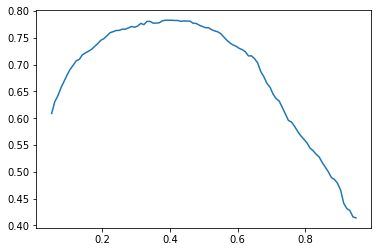

In [17]:
probasPredTrain = probasPredTrain/5
probasPred = probasPred/5

threshF1 = []
threshVal = []

for i in np.linspace(0.05,0.95,100):
    threshF1.append(f1_score(train['m13'],(probasPredTrain>i)*1))
    threshVal.append(i)

plt.plot(threshVal,threshF1)

np.array(threshF1).argmax()

labels = (probasPred>threshVal[(np.array(threshF1).argmax())])*1

**HERE WE HAVE OUR FIRST MODEL SUBMISSION FROM CATBOOST**

* **One-Hot Encoding Trials for XGB and LGBM**


In [18]:
data = pd.concat([train.drop(columns=['m13']),test])

data.head()

data = pd.get_dummies(data,columns=categorical,prefix='dum')

train_new = data.iloc[:len(train)]
test_new = data.iloc[len(train):]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_new = sc.fit_transform(train_new)
test_new = sc.transform(test_new)

# from sklearn.decomposition import PCA
# pca = PCA(n_components = 180)
# train_new = pca.fit_transform(train_new)
# test_new = pca.transform(test_new)

In [19]:
from xgboost import XGBClassifier
from imblearn.under_sampling import TomekLinks

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [20]:
f1 = 0
probasPred = np.zeros(len(test))
probasPredTrain = np.zeros(len(train))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train_new, train['m13'].values))):
    X_train = (train_new)[trn_idx]
    X_test = (train_new)[val_idx]
    y_train = train['m13'][trn_idx]
    y_test = train['m13'][val_idx]
    clf = XGBClassifier(colsample_bytree=0.57574225920725,learning_rate=0.12524888976943854,max_delta_step=0.23218201667538563,
             max_depth=15,min_child_weight=11.522073006203208,reg_alpha=6.779851915666066,
              reg_lambda=6.682134255966473,scale_pos_weight=2.556586526453567,subsample=0.7805883424057105,
            eval_metric='auc')
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    f1 += f1_score(y_test,preds)
    print('Current f1 is:' + str(f1/(fold_+1)))
    #probasPredTrain += clf.predict_proba((train_new))[:,1]
    probasPredTrain[val_idx] = clf.predict_proba(X_test)[:,1]
    probasPred += clf.predict_proba(test_new)[:,1]

Current f1 is:0.6063348416289593
Current f1 is:0.5680076034628816
Current f1 is:0.5626838020069286
Current f1 is:0.5522454096447313
Current f1 is:0.5413354982226976



In [21]:
probasPred = probasPred/5

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


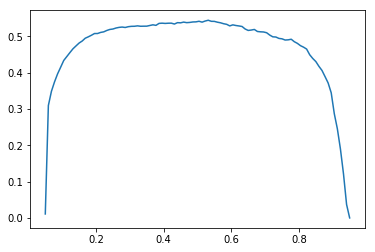

In [22]:
threshF1 = []
threshVal = []

for i in np.linspace(0.05,0.95,100):
    threshF1.append(f1_score(train['m13'],(probasPredTrain>i)*1))
    threshVal.append(i)

plt.plot(threshVal,threshF1)

In [23]:
print(np.array(threshF1).max())
print(np.array(threshF1).argmax())
labels = (probasPred>threshVal[(np.array(threshF1).argmax())])*1

0.5446009389671361
53


**HERE WE HAVE OUR SECOND MODEL SUBMISSION FROM XGBOOST**

**Applying LightBoost**

In [24]:
f1 = 0
probasPred = np.zeros(len(test))
probasPredTrain = np.zeros(len(train))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train_new, train['m13'].values))):
    X_train = (train_new)[trn_idx]
    X_test = (train_new)[val_idx]
    y_train = train['m13'][trn_idx]
    y_test = train['m13'][val_idx]
    clf = LGBMClassifier(scale_pos_weight=10.12,learning_rate=0.1322,max_depth=36,
                     min_data_in_leaf=213,reg_alpha=11.01,reg_lambda=9.281,num_leaves=996)
    clf.fit(X_train,y_train)
    preds = clf.predict(X_test)
    f1 += f1_score(y_test,preds)
    print('Current f1 is:' + str(f1/(fold_+1)))
    probasPredTrain[val_idx] = clf.predict_proba(X_test)[:,1]
    probasPred += clf.predict_proba(test_new)[:,1]

Current f1 is:0.5551330798479087
Current f1 is:0.5303967286031996
Current f1 is:0.4937687592397399
Current f1 is:0.4860128439396088
Current f1 is:0.466732353073765



In [25]:
probasPred = probasPred/5

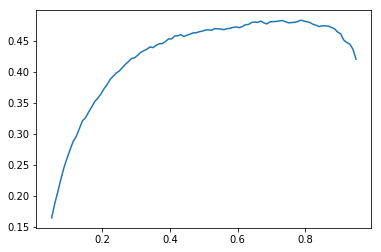

In [26]:
threshF1 = []
threshVal = []

for i in np.linspace(0.05,0.95,100):
    threshF1.append(f1_score(train['m13'],(probasPredTrain>i)*1))
    threshVal.append(i)

plt.plot(threshVal,threshF1)

In [27]:
print(np.array(threshF1).max())
print(np.array(threshF1).argmax())
labels = (probasPred>threshVal[(np.array(threshF1).argmax())])*1

0.4826325411334552
81


**HERE WE HAVE OUR THIRD MODEL SUBMISSION FROM LIGHTBOOST**

**UNDERSAMPLING TO HANDLE THE IMBALANCE IN THE DATASET**

Undersampling is done using **Tomek Links**

I have commented out the codes for Tomek Link implementation as the Tomek Link process being extremely slow, it takes a lot of time to run and it exceeds the time limit for commiting to Kaggle notebooks.

But the entire working code has been attached below.

In [28]:
# f1 = 0
# probasPred = np.zeros(len(test))
# probasPredTrain = np.zeros(len(train))

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train_new, train['m13'].values))):
#     X_train = (train_new)[trn_idx]
#     X_test = (train_new)[val_idx]
#     y_train = train['m13'][trn_idx]
#     y_test = train['m13'][val_idx]
#     tk = TomekLinks()
#     X_train_res, y_train_res = tk.fit_resample(X_train, y_train.ravel())
#     clf = LGBMClassifier(scale_pos_weight=10.12,learning_rate=0.1322,max_depth=36,
#                      min_data_in_leaf=213,reg_alpha=11.01,reg_lambda=9.281,num_leaves=996)
#     clf.fit(X_train_res,y_train_res)
#     preds = clf.predict(X_test)
#     f1 += f1_score(y_test,preds)
#     print('Current f1 is:' + str(f1/(fold_+1)))
#     probasPredTrain[val_idx] = clf.predict_proba(X_test)[:,1]
#     probasPred.append(clf.predict(test_new))

In [29]:
# probasPred = probasPred/5

In [30]:
# threshF1 = []
# threshVal = []

# for i in np.linspace(0.05,0.95,100):
#     threshF1.append(f1_score(train['m13'],(probasPredTrain>i)*1))
#     threshVal.append(i)

# plt.plot(threshVal,threshF1)

In [31]:
# print(np.array(threshF1).max())
# print(np.array(threshF1).argmax())
# labels = (probasPred>threshVal[(np.array(threshF1).argmax())])*1

**WE HAVE OUR FOURTH MODEL SUBMISSION FROM TOMEK UNDERSAMPLING AND LIGHTBOOST**

In [32]:
# f1 = 0
# probasPred = np.zeros(len(test))
# probasPredTrain = np.zeros(len(train))

# folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(train_new, train['m13'].values))):
#     X_train = (train_new)[trn_idx]
#     X_test = (train_new)[val_idx]
#     y_train = train['m13'][trn_idx]
#     y_test = train['m13'][val_idx]
#     tk = TomekLinks()
#     X_train_res, y_train_res = tk.fit_resample(X_train, y_train.ravel())
#     clf = XGBClassifier(colsample_bytree=0.5126,learning_rate=0.02512,max_delta_step=5.431,max_depth=15,min_child_weight=4.108,reg_alpha=6.16,
#                         reg_lambda=4.111,scale_pos_weight=3.9,subsample=0.5776,eval_metric='auc',tree_method='gpu_hist')
#     clf.fit(X_train_res,y_train_res)
#     preds = clf.predict(X_test)
#     f1 += f1_score(y_test,preds)
#     print('Current f1 is:' + str(f1/(fold_+1)))
#     probasPredTrain[val_idx] = clf.predict_proba(X_test)[:,1]
#     probasPred.append(clf.predict(test_new))

In [33]:
# probasPred = probasPred/5

In [34]:
# threshF1 = []
# threshVal = []

# for i in np.linspace(0.05,0.95,100):
#     threshF1.append(f1_score(train['m13'],(probasPredTrain>i)*1))
#     threshVal.append(i)

# plt.plot(threshVal,threshF1)

In [35]:
# print(np.array(threshF1).max())
# print(np.array(threshF1).argmax())
# labels = (probasPred>threshVal[(np.array(threshF1).argmax())])*1

**HERE WE HAVE THE FIFTH MODEL SUBMISSION FROM TOMEK LINKS AND XGBOOST**

Bayesian Optimization was used for Tuning the models and getting the optimal hyper-parameters for the models used and also for stacking with optimal weights.


Stacking on these 5 models further gives the score a push. 

The models are summarised again below - 

1.CatBoost on Normal Data.

2.XGBoost on One Hot Encoded, Scaled Data.

3.LGBM on One Hot Encoded, Scaled Data.

4.XGBoost on Tomek Links Undersampled Data.

5.LGBM on Tomek Links Undersampled Data.

Things which I tried but didnt work out for this problem - 

1.**Dense Neural Networks**

2.**Fast AI Tabular Learner**

3.**Applying PCA on the Dataset** - This approach failed miserably, hinting towards a possibility of the train and the test set having different distributions, due to which most of the data from the test set is lost on applying PCA which is trained on the train set.


In [36]:
tester = pd.read_csv('../input/test.csv')

submission = pd.DataFrame({'loan_id':tester['loan_id'],'m13':labels})

from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "subm.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(submission)

Here is the link of the final CSV generated from the notebook post stacking - 

https://drive.google.com/open?id=15wbLEbMv3xUWBCMqndzNZeK-mowAHFut


**Now that we have reached the end of the kernel, I am assuming you liked the kernel, since you didnt close it mid-way.**

**If you did like it, please UPVOTE the kernel. That keeps me going !
**

**Any suggestions and criticism are welcome.**

**Cheers !**